The goal of this notebook is to generate a plot that shows the fraction of EUR and EAS cell lines with each SNV

In [2]:
#Set up the environment
library(tidyverse)
library(reshape2)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [3]:
#First extract the sample names from the vcf file, then load them into R
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides
/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.ancestry.guides.vcf.gz > ccle.sample.names.txt
"))

setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
sample.names = read.table("ccle.sample.names.txt", sep = "\t") %>%
pull(1)
head(sample.names)

[1] "ACH-000657" "ACH-000617" "ACH-000685" "ACH-000632" "ACH-000171"
[6] "ACH-000863"

In [4]:
#Now load in the subset vcf file and format it
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
subset.ccle.snps = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub(":..*", "", x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("0\\|0", 0, x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("0\\|1", 1, x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("1\\|0", 1, x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("1\\|1", 2, x) })

#Fix the SNP column
subset.ccle.snps = subset.ccle.snps %>%
separate(V3, sep = ":", into = c("chr", "pos", "ref", "alt"))

In [5]:
#Format a matrix with the SNP-level data that is annotated with the cell line names
snp.level.data.matrix = subset.ccle.snps
colnames(snp.level.data.matrix) = c("chr", "pos", "ref", "alt", sample.names)
head(snp.level.data.matrix)

,chr,pos,ref,alt,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,1407014,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1,1471992,T,C,2,2,1,0,1,0,⋯,1,2,2,2,0,1,1,1,0,0
3,chr1,1918305,G,A,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,1
4,chr1,2028260,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1,2351722,A,G,2,0,1,1,0,0,⋯,0,1,0,2,0,0,0,0,1,0
6,chr1,2408761,T,C,1,2,2,2,2,2,⋯,2,2,2,2,1,1,0,2,1,2


In [6]:
#Load in the ancestry data
setwd("/home/jupyter/Ancestry/rfmix")
ancestry.information = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T)

#Get a vector of the EAS and EUR cell lines
eas.lines = ancestry.information %>% filter(EAS >= 0.8) %>% pull(sample)
eur.lines = ancestry.information %>% filter(EUR >= 0.8) %>% pull(sample)

In [7]:
###Now calculate the frequency of cell lines that are either 0/1 or 1/1 for the SNP

#First splice the dataset into just the EAS and EUR cell lines
eas.genotype.data = snp.level.data.matrix[,eas.lines]
eur.genotype.data = snp.level.data.matrix[,eur.lines]

#Count the total number of cell lines with the SNP
eas.snp.count = eas.genotype.data %>% apply(1, function(x){
    num.with.snp = x[x >= 1] %>% length()
    return(num.with.snp)
})

eur.snp.count = eur.genotype.data %>% apply(1, function(x){
    num.with.snp = x[x >= 1] %>% length()
    return(num.with.snp)
})


#Now convert it into a fraction
eas.snp.frequency = eas.snp.count/ncol(eas.genotype.data)
eur.snp.frequency = eur.snp.count/ncol(eur.genotype.data)

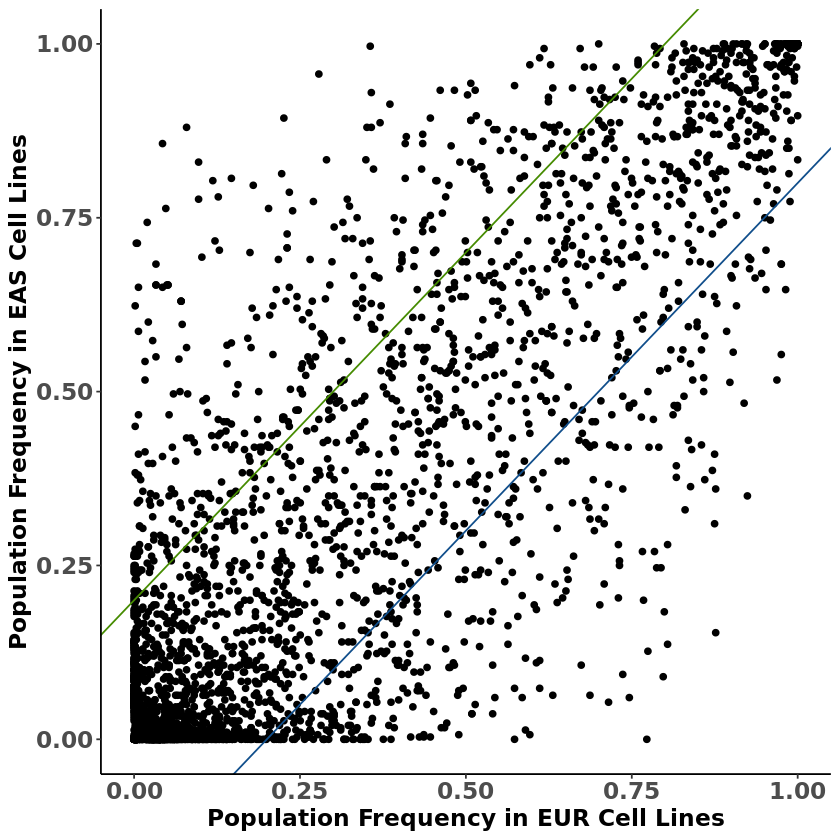

In [8]:
#Bind everything togehter, then plot it.

#Make the matrix
snp.frequency.matrix = snp.level.data.matrix %>%
select(chr, pos, ref, alt) %>%
cbind(., eas.snp.frequency, eur.snp.frequency)


#Make the scatterplot
snp.frequency.matrix %>%
ggplot() +
geom_point(aes(x = eur.snp.frequency, y = eas.snp.frequency)) +
geom_abline(intercept = -0.2, slope = 1, col = "dodgerblue4") +
geom_abline(intercept = 0.2, slope = 1, col = "chartreuse4") +
theme_bw() + 

ylab("Population Frequency in EAS Cell Lines") +
xlab("Population Frequency in EUR Cell Lines") +

theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +

theme(axis.text=element_text(size=12), axis.title=element_text(size=14,face="bold")) +
theme(axis.text.x = element_text(face="bold", size=14), axis.text.y = element_text(face="bold", size=14)) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
) +

xlim(c(0,1)) +
ylim(c(0,1))

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("ccle_allele_frequency_all_guides.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp ccle_allele_frequency_all_guides.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [28]:
#Now let's calculate the number of SNVs that are below the line (or above the line)
differential.snp.frequency.matrix = snp.frequency.matrix %>%
mutate("eas_over_eur" = eas.snp.frequency - eur.snp.frequency) %>%
mutate("eur_over_eas" = eur.snp.frequency - eas.snp.frequency)

head(snp.frequency.matrix)
head(differential.snp.frequency.matrix)

number.eas = differential.snp.frequency.matrix %>% 
filter(eas_over_eur > 0.2) %>%
nrow()

number.eur = differential.snp.frequency.matrix %>%
filter(eur_over_eas > 0.2) %>%
nrow()

number.eas
number.eur
nrow(differential.snp.frequency.matrix)

100*(number.eas/nrow(differential.snp.frequency.matrix))
100*(number.eur/nrow(differential.snp.frequency.matrix))

,chr,pos,ref,alt,eas.snp.frequency,eur.snp.frequency
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,chr1,1407014,G,A,0.0000000,0.01976936
2,chr1,1471992,T,C,0.9966667,0.35584843
3,chr1,1918305,G,A,0.2366667,0.08237232
4,chr1,2028260,G,A,0.0000000,0.02306425
5,chr1,2351722,A,G,0.2500000,0.23723229
6,chr1,2408761,T,C,0.9166667,0.91598023


,chr,pos,ref,alt,eas.snp.frequency,eur.snp.frequency,eas_over_eur,eur_over_eas
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,1407014,G,A,0.0000000,0.01976936,-0.019769357,0.019769357
2,chr1,1471992,T,C,0.9966667,0.35584843,0.640818232,-0.640818232
3,chr1,1918305,G,A,0.2366667,0.08237232,0.154294344,-0.154294344
4,chr1,2028260,G,A,0.0000000,0.02306425,-0.023064250,0.023064250
5,chr1,2351722,A,G,0.2500000,0.23723229,0.012767710,-0.012767710
6,chr1,2408761,T,C,0.9166667,0.91598023,0.000686436,-0.000686436


[1] 382

[1] 358

[1] 3432

[1] 11.13054

[1] 10.43124